In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os
from shapely.geometry import Polygon
import pickle

Key meta data

In [2]:
root_path = "D:/GeoData/"
Main_CRS = "EPSG:27700"

Shapefiles

In [3]:
Shape_Loc = {
    'All_GB' : root_path + "Countries__December_2019__Boundaries_UK_BFC-shp/Countries__December_2019__Boundaries_UK_BFC.shp",
    'National_Parks' : root_path + "National_Parks__December_2019__GB_BFE-shp/National_Parks__December_2019__GB_BFE.shp",
    'LocalAuthorities' : root_path + "Local_Authority_Districts__May_2020__Boundaries_UK_BFC-shp/Local_Authority_Districts__May_2020__Boundaries_UK_BFC.shp",
    'LSOA' : root_path + "Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2-shp/Lower_Layer_Super_Output_Area__December_2011__EW_BSC_V2.shp",
    'GreenSpace' : root_path + "opgrsp_essh_gb/OS Open Greenspace (ESRI Shape File) GB/data/GB_GreenspaceSite.shp",
    'Rivers' : root_path + "oprvrs_essh_gb/data/WatercourseLink.shp"}

In [4]:
All_Maps = dict((k, gpd.read_file(v).to_crs(Main_CRS)) for k, v in Shape_Loc.items())

In [5]:
file = os.listdir("D:\GeoData\oproad_essh_gb\data")

path = [os.path.join("D:\GeoData\oproad_essh_gb\data", i) for i in file if "RoadLink.shp" in i]

All_Maps['Road_Link'] = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path], 
                        ignore_index=True), crs=Main_CRS)

In [6]:
path = [os.path.join("D:\GeoData\oproad_essh_gb\data", i) for i in file if "MotorwayJunction.shp" in i]

All_Maps['MotorwayJunctions'] = gpd.GeoDataFrame(pd.concat([gpd.read_file(i) for i in path], 
                        ignore_index=True), crs=Main_CRS)

In [7]:
All_Maps['Motorway'] = All_Maps['Road_Link'][All_Maps['Road_Link']['class'] == "Motorway"]
All_Maps['A_Roads'] = All_Maps['Road_Link'][All_Maps['Road_Link']['class'] == "A Road "]
All_Maps['B_Roads'] = All_Maps['Road_Link'][All_Maps['Road_Link']['class'] == "B Road"]
All_Maps['Other_roads'] = All_Maps['Road_Link'][~All_Maps['Road_Link']["class"].isin([ "Motorway", "A Road", "B Road"])]

del All_Maps['Road_Link']

Points files

In [8]:
NSPL_Data = pd.read_pickle(root_path + 'WorkingData/' + 'NSPL_Data.pickle')
All_Maps['NSPL_gdf'] = gpd.GeoDataFrame(NSPL_Data, geometry=gpd.points_from_xy(NSPL_Data.oseast1m, NSPL_Data.osnrth1m), crs=Main_CRS)

del NSPL_Data

In [9]:
LandReg = pd.read_pickle(root_path + 'WorkingData/' + 'LandReg.pickle')
All_Maps['LandReg_gdf'] = gpd.GeoDataFrame(LandReg, geometry=gpd.points_from_xy(LandReg.oseast1m, LandReg.osnrth1m), crs=Main_CRS)

del LandReg

In [10]:
#UDPRNs = pd.read_pickle(root_path + 'WorkingData/' + 'NSUL_Data.pickle')
#All_Maps['UDPRNs_gdf'] = gpd.GeoDataFrame(UDPRNs, geometry=gpd.points_from_xy(UDPRNs.gridgb1e, UDPRNs.gridgb1n), crs=Main_CRS)

#del UDPRNs
#All_Maps['UDPRNs_gdf'].head()

Functions for clipping and saving the maps

In [11]:
def MakePolygon(centre, sq_sz, inp_crs):
    mnx = centre[0]-(sq_sz/2)
    mny = centre[1]-(sq_sz/2)
    mxx = centre[0]+(sq_sz/2)
    mxy = centre[1]+(sq_sz/2)
    polygon =Polygon([(mnx, mny), (mnx,mxy), (mxx,mxy), (mxx,mny), (mnx, mny)])
    poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs=inp_crs)
    return poly_gdf

In [12]:
def save_obj(name , obj, extra=""):
    with open(root_path + 'WorkingData/' + extra + name + '.pkl', 'wb+') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [13]:
def load_obj(name ):
    with open(root_path + 'WorkingData/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [14]:
def ClipAndSave(name, centre, sq_sz, crs, extra):
    print(name)
    poly = MakePolygon(centre, sq_sz, crs)
    maps = dict((k, gpd.clip(v, poly)) for k, v in All_Maps.items())
    save_obj(name , maps, extra)
    return maps

Clip and save the maps

In [15]:
save_obj('All_Maps' , All_Maps)

In [19]:
KeyLocations = {'Sydenham' : [535493, 171250],
                'Cumbria' : [326877 , 474372],
                'Croydon' : [532621 , 165313],
                'StPauls' : [532052 , 181145],
                'ElephantCastle' : [531958 , 179077],
                'M4_junct' : [519377 , 178360],
                'M6_Junctions' : [357659 , 425462]}

In [20]:
ClippedMaps_5k = dict((k, ClipAndSave(k, v, 5000, Main_CRS, "Clipped5k_")) for k, v in KeyLocations.items())

Sydenham
Cumbria
Croydon
StPauls
ElephantCastle
M4_junct
M6_Junctions


In [21]:
save_obj('ClippedMaps_5k' , ClippedMaps_5k)

In [28]:
def printMap(Mapset):
    ax = Mapset['All_GB'].plot(figsize=(20,20), color='white', edgecolor='grey')

    Mapset['Other_roads'].plot(ax=ax, color='black', linewidth=0.3)
    Mapset['Motorway'].plot(ax=ax, color='black', linewidth=3)
    Mapset['A_Roads'].plot(ax=ax, color='black', linewidth=2)
    Mapset['B_Roads'].plot(ax=ax, color='black', linewidth=1)
    Mapset['Rivers'].plot(ax=ax, color='blue', linewidth=0.2, alpha=1)
    Mapset['National_Parks'].plot(ax=ax, color='green', alpha=0.5)
    Mapset['GreenSpace'].plot(ax=ax, color='green', alpha=0.7)

    Mapset['LandReg_gdf'].plot(ax=ax, color='black', alpha=1, markersize=10)

C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


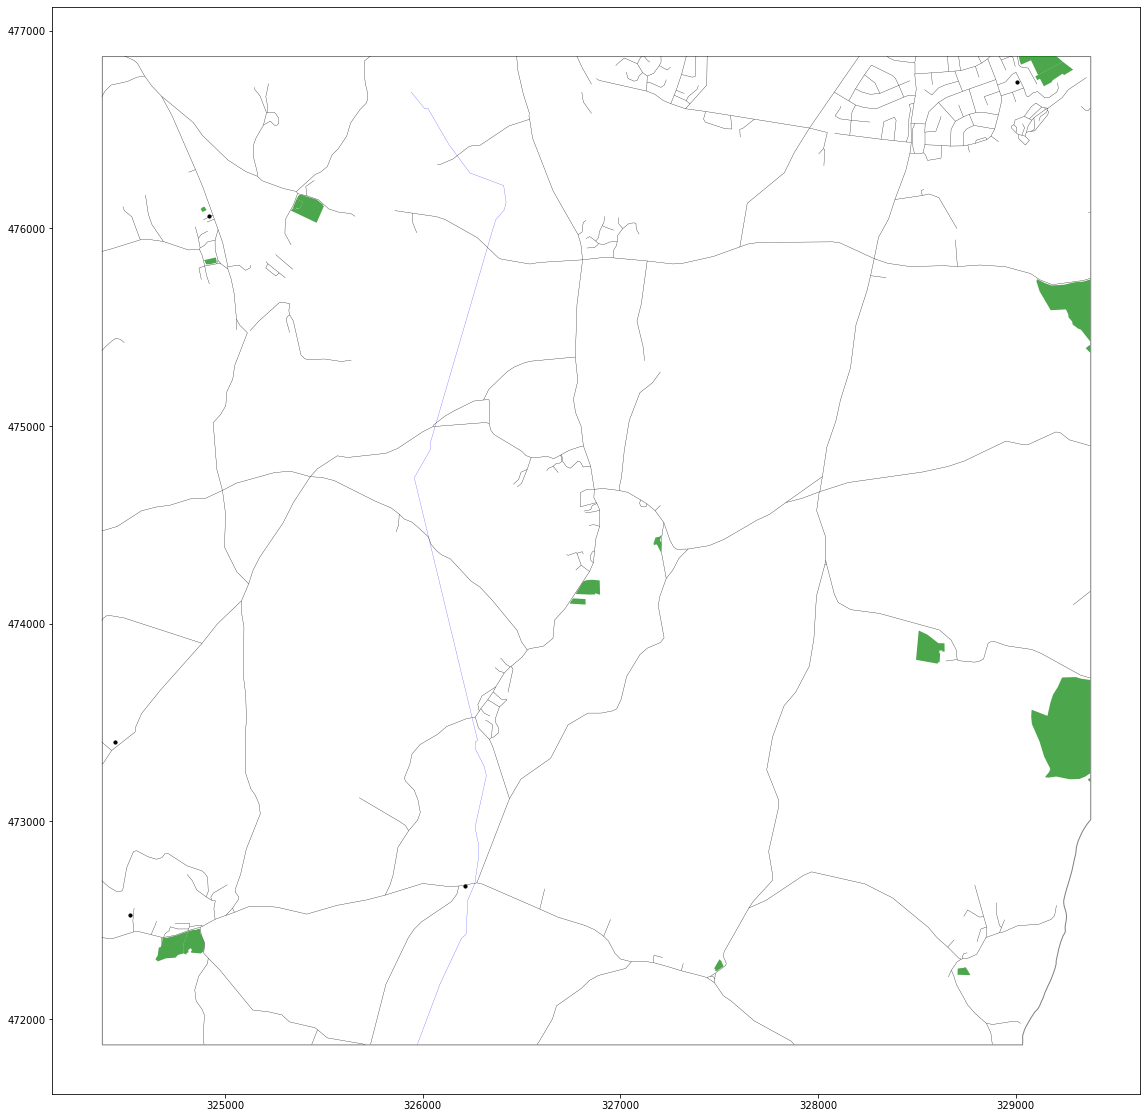

In [29]:
printMap(ClippedMaps_5k["Cumbria"])

C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


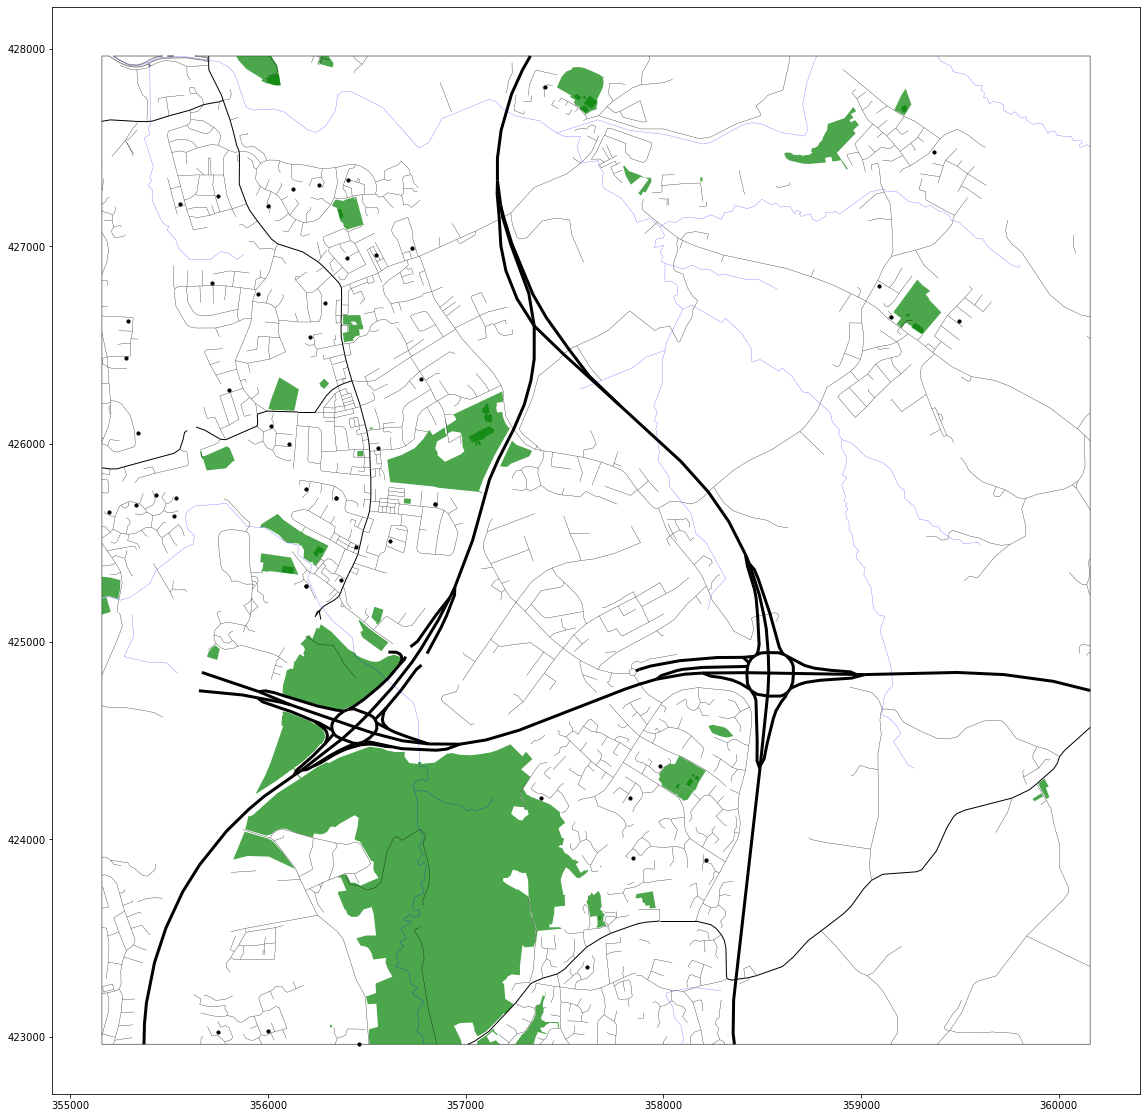

In [30]:
printMap(ClippedMaps_5k["M6_Junctions"])

C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


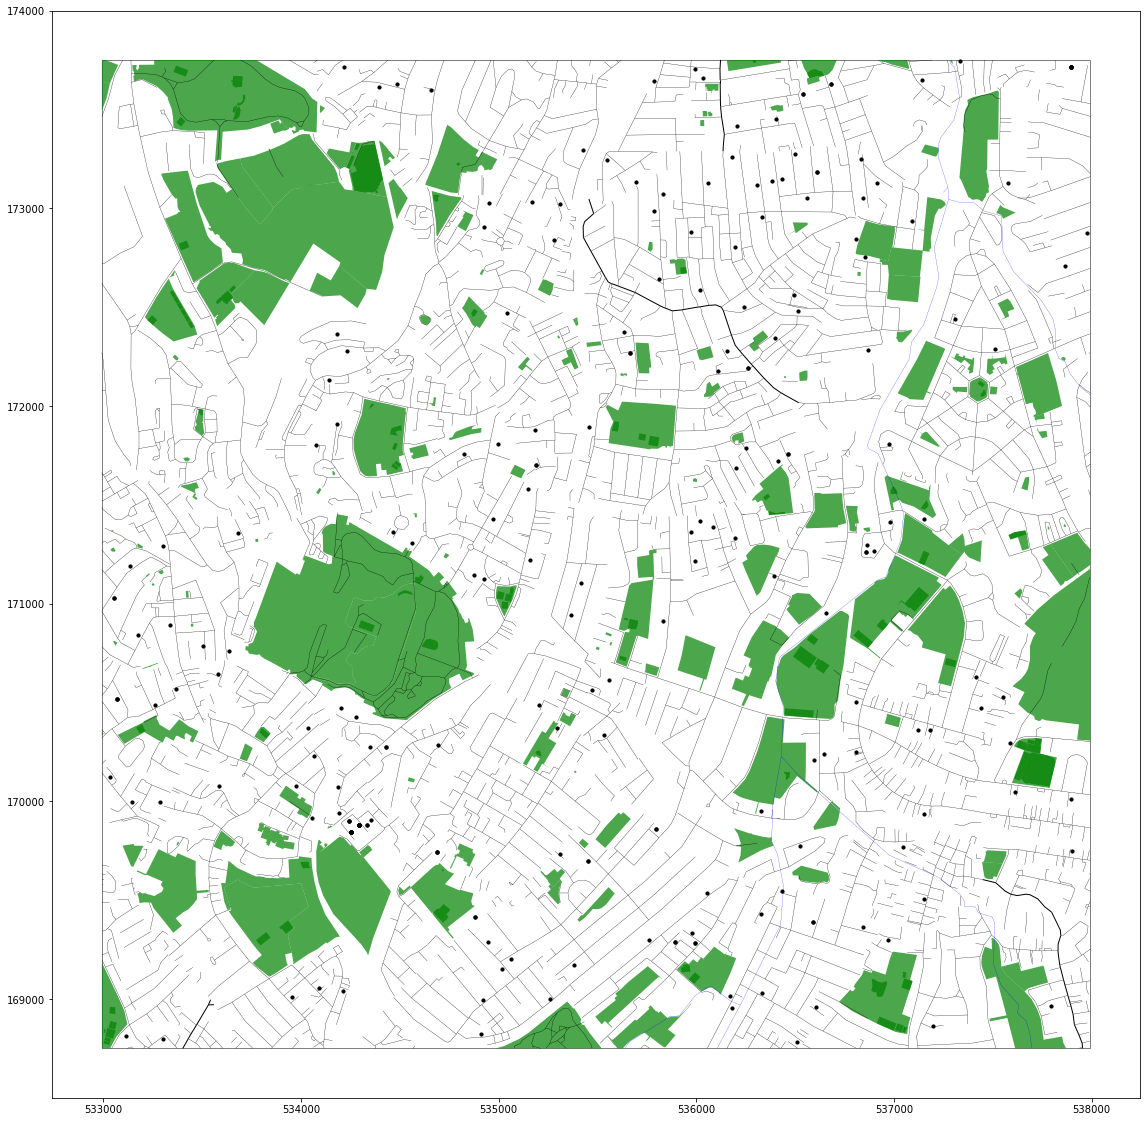

In [31]:
printMap(ClippedMaps_5k["Sydenham"])

C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
C:\Users\richa\Anaconda3\envs\Landreg\lib\site-packages\geopandas\plotting.py:604: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


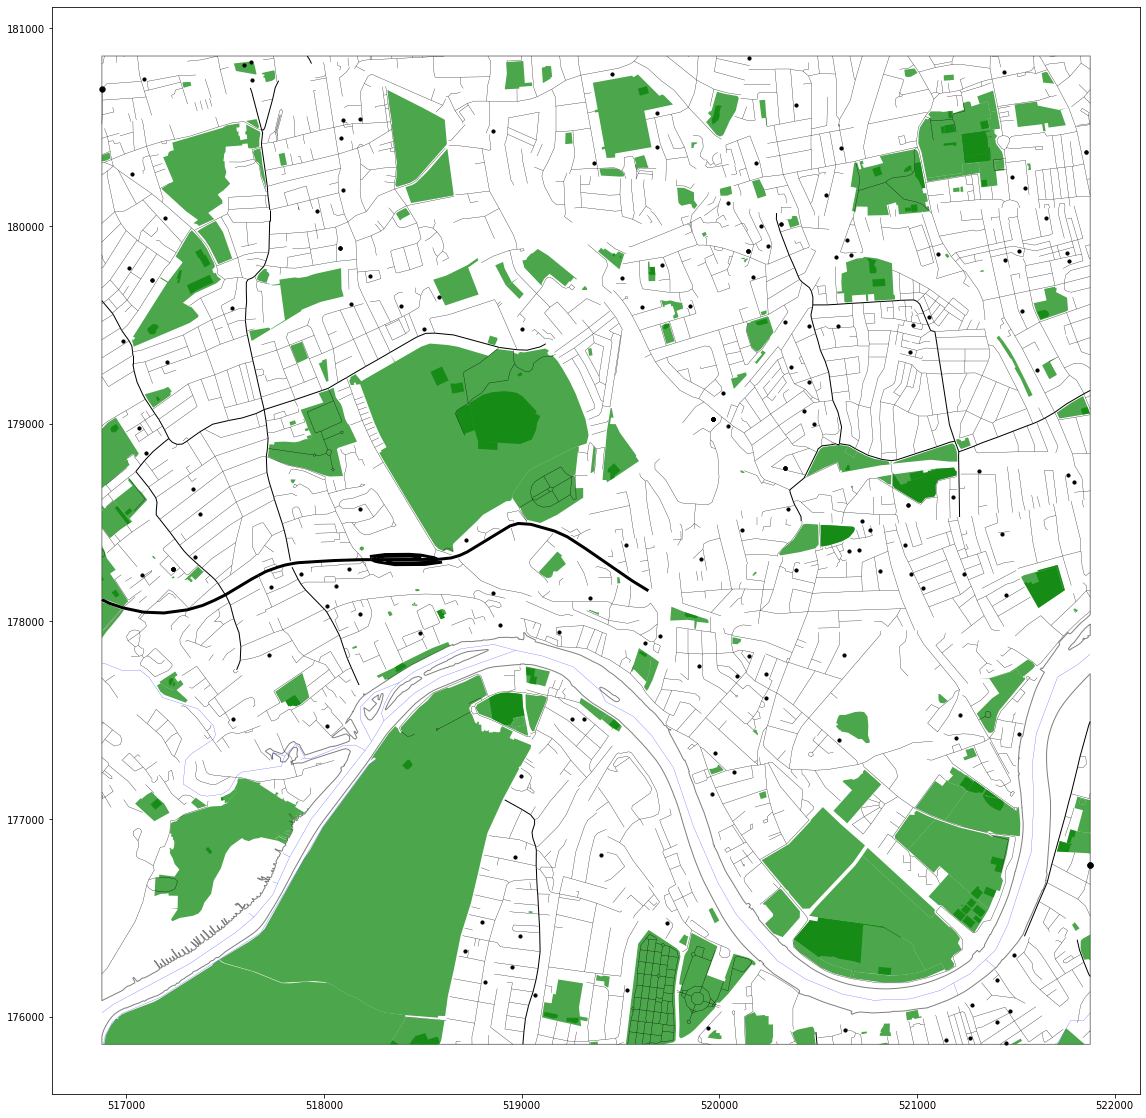

In [32]:
printMap(ClippedMaps_5k["M4_junct"])

# Next tasks

* Blog the above
* Add crashes from stat 19
* Add police crime data
* Add raster for some sort of geology data